# Implementation of a naive Bayes classifier for checking spam\non-spam emails

Our task is to calculate the most probable class, so we need to calculate the value of the random variable $C$ at which the posteriori maximum is reached

$$C = argmax P(c|d) \quad c \in C$$

According to Bayes' theorem , we decompose P(c|d)

$$C = argmax \frac{P(d|c)*P(c)}{P(d)}$$

Considering that we are looking for an argument that maximizes the likelihood function, and that the denominator does not depend on this argument and is a constant in this case, we can cross out the value of the composite probability P(d)

$$C = argmax P(d|c)*P(c)$$

Since the maximum of any function f(x) will be identical to the maximum of ln(f(x)), then

$$C = arg max ln(P(d|c)*P(c))$$

Given the naivety of our classifier and the property of the logarithm:

$$C = arg max ln(P(f_1,f_2,...,f_n|c)*P(c)) \newline
= arg max ln(P(c)*\prod_{i=1}^{n} P(f_i,c)) \newline
= arg max ln(P(c))+\sum_{i=1}^{n} ln(P(f_i,c)) $$

So, using the maximum likelihood method and Laplace blur, we get:
$$ P(f_i,c_j) = \frac{count(f_i,c_j) + z}{\sum_{k=1}^{q} count(f_k,c_j) + zq} \newline$$
Where z >= 0 - blur factor ,q - total number of words

#### Let's start implementing our classifier

In [1]:
# Imports
from math import log
import pandas as pd 
import numpy as np
from typing import Dict, List
from sklearn.model_selection import train_test_split
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset and shuffling it
data =  pd.read_csv("input/spam_or_not_spam.csv")
data.dropna(inplace = True)
data = data.sample(frac=1).reset_index(drop=True) 

#labels and mail
X =  data.iloc[:,0].values
y = data.iloc[:,-1].values


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

class Preprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocessing the entire dataset
    """
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        ps = PorterStemmer()
        for i in range(len(X)):
            X[i] = X[i].lower()
            stop_words = set(stopwords.words('english'))
  
            word_tokens = word_tokenize(X[i])
            
  
            filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stop_words]
            
            X[i] = ' '.join(filtered_sentence)
  
            

        return X

In [4]:
class NaiveBayesClassificationModel():
    
    def __init__(self, X, y, blur_factor: int):
        self.count_spam: int = 0
        self.count_not_spam: int  = 0
        self.count_total: int = 0
        self.blur_factor: int = blur_factor
        self.total_sum: int = 0
            
        self.bag_of_words_spam: Dict[str, int] = {}
        self.bag_of_words_not_spam: Dict[str, int] = {}
            
            
        # Calculate the number of words related to the spam\non-spam categories
        for i in range(len(X)):
            if(y[i] == 1):
                self.count_spam += 1
            if(y[i] == 0):
                self.count_not_spam += 1
            self.count_total = self.count_not_spam + self.count_spam
            
        # Define dicts of 'bag of words' for spam\unspam emails
        for i in range(len(X)):
            sentence_split = X[i].split(' ')
            if(y[i] == 1):
                for v in sentence_split:
                    if(v not in self.bag_of_words_spam.keys()):
                        self.bag_of_words_spam[v] = 1
                    else:
                        self.bag_of_words_spam[v] = self.bag_of_words_spam[v] + 1
            
            if(y[i] == 0):
                for v in sentence_split:
                    if(v not in self.bag_of_words_not_spam.keys()):
                        self.bag_of_words_not_spam[v] = 1
                    else:
                        self.bag_of_words_not_spam[v] = self.bag_of_words_not_spam[v] + 1        
                

            
            
            
    def count_word_in_bag_of_words(self, word: str, bag: Dict[str, int]) -> str:
        """
        count_word_in_bag_of_words - Counting the number of occurrences of a word in a dict of 'bag of words'
        """
        if(word not in bag.keys()):
            return 0
        else:
            return bag[word]
        
    
    def sum_words_in_bag_of_words(self, bag: Dict[str, int]) -> int:
        """
        sum_words_in_bag_of_words - Counting words in a dict of 'bag of words'
        """
        return sum(bag.values())
    
    
    def calculating_final_probability_spam(self, sentence: str) -> float:
        """
        calculating_final_probability_spam - Calculating the final probability for a letter for spam object
        """
        split_sentence = sentence.split(' ')
        try:
            probability_spam = log(self.count_spam/self.count_total)
            for word in split_sentence:
                probability_spam += log((self.count_word_in_bag_of_words(word, self.bag_of_words_spam) + self.blur_factor)
                                        /(self.sum_words_in_bag_of_words(self.bag_of_words_spam) 
                                          +(self.blur_factor * self.total_sum)))
        except ValueError and ZeroDivisionError:
            probability_spam = 0
            
        return probability_spam
            
            
    def calculating_final_probability_not_spam(self, sentence: str) -> float:
        """
        calculating_final_probability_not_spam - Calculating the final probability for a letter for not spam object
        """
        split_sentence = sentence.split(' ')
        try:
            probability_not_spam = log((self.count_not_spam)/self.count_total)
            for word in split_sentence:
                probability_not_spam += log((self.count_word_in_bag_of_words(word, self.bag_of_words_not_spam) 
                                             + self.blur_factor)
                                            /(self.sum_words_in_bag_of_words(self.bag_of_words_not_spam) 
                                              +(self.blur_factor * self.total_sum)))
        except ValueError and ZeroDivisionError:
            probability_not_spam = 0
            
        return probability_not_spam
            
    
    def determine(self, sentence: str) -> int:
        """
        determine - Determining if the email is spam
        """
            
        
        probability_spam: float = self.calculating_final_probability_spam(sentence)
        probability_not_spam: float = self.calculating_final_probability_not_spam(sentence)
        
        if(probability_not_spam>probability_spam):
            return 0
        else:
            return 1      
            
    def test_model(self, X, y) -> float:
        """
        test_model - Calculation of cross_val_score
        """
        # Calculate the number of words in both dicts
        self.total_sum = (self.sum_words_in_bag_of_words(self.bag_of_words_spam)
                          + self.sum_words_in_bag_of_words(self.bag_of_words_not_spam))
        
        success: int = 0
        for i in range(len(X)):
            if(self.determine(X[i]) == y[i]):
                success += 1

        return success/len(X)

In [5]:
class CrossValidation():
    def plot(self, blur_factor: List[int], cross_val_score: List[float]):
        plt.xlabel("blur factor") 
        plt.ylabel("cross val score") 
        plt.grid() 
        plt.plot(blur_factor, cross_val_score)
        plt.show()
        
    def fit(self, X, y=None):
        return self
    
    
    def find_best_blur_factor(self, X, y):
        """
        find_best_blur_factor - Splitting the dataset into 10 parts and finding the best blur factor
        """
        
        best_blur_factor: int = 1
        cross_val_score: float = 0
            
        blur_factor_list: List[int] = []
        cross_val_score_list: List[float] = []
            
        chunks_X = np.array_split(X, 9)
        chunks_y = np.array_split(y, 9)
        
        for i in range(len(chunks_X)):
            X_train = []
            y_train = []
            for j in range(len(chunks_X)):
                if(j != i):
                    X_train.extend(chunks_X[j])
                    y_train.extend(chunks_y[j])
                    
            model = NaiveBayesClassificationModel(X_train, y_train, i+1)
            cross_val_score_list.append(model.test_model(chunks_X[i], chunks_y[i]))
            blur_factor_list.append(i+1)
            
            if(cross_val_score < cross_val_score_list[-1]):
                cross_val_score = cross_val_score_list[-1]
                best_blur_factor = i+1
                
        self.plot(blur_factor_list, cross_val_score_list)    
        
        return best_blur_factor 
        
    def transform(self, X):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        best_blur_factor = self.find_best_blur_factor(X_train,y_train)
        
        model = NaiveBayesClassificationModel(X_train,y_train, best_blur_factor)
        accurancy = model.test_model(X_test, y_test)
        print(f'best blur factor is: {best_blur_factor}')
        print(f'cross validation score is: {accurancy}')
        
        
        

<IPython.core.display.Javascript object>


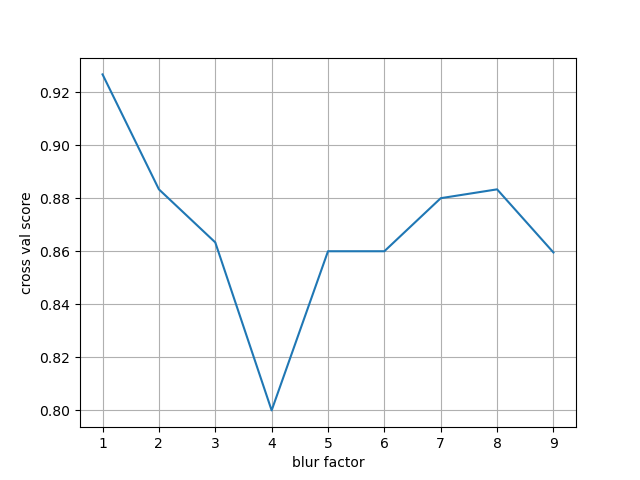

best blur factor is: 1
cross validation score is: 0.91


In [6]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessing', Preprocessor()),
    ('cross_val', CrossValidation()),
])

pipeline.fit_transform(X, y)
